In [1]:
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso
from sklearn import metrics
import matplotlib.pyplot as plt

import sys
sys.path.append("../") # go to parent dir
sys.path.append("../../") # go to parent parent dir
sys.path.append("../helpers/")
sys.path.append("../helpers/utils")
sys.path.append("../helpers/central")
import utils
import sparse_linreg_peeling


In [2]:
data = pd.read_table("../data/genome.txt", sep = "\t")
data.head()

,DDR1,MIR4640,RFC2,HSPA6,PAX8,GUCA1A,MIR5193,UBA7,THRA,PTPN21,...,LOC100129924,FAM86B1,FAM86B2,FAM86DP,FAM86FP,SNHG17,LOC100505915,GSM,disease,FAB
0,7.135135,7.135135,6.482099,6.676021,6.645632,6.382956,9.792603,9.792603,6.519152,5.807912,...,5.566997,7.410738,7.410738,7.410738,7.410738,7.482258,5.944763,1,AML,M2
1,7.379455,7.379455,6.824016,6.575389,6.866953,5.777188,9.868853,9.868853,6.739256,5.394392,...,6.389914,7.684605,7.684605,7.684605,7.684605,7.800407,6.344267,2,AML,M4
2,7.776574,7.776574,6.777692,6.833048,6.740570,5.758784,9.503343,9.503343,6.585977,5.269234,...,6.359589,7.432409,7.432409,7.432409,7.432409,7.514223,6.742695,3,AML,M2
3,7.610568,7.610568,6.876088,6.331511,6.806035,5.697665,10.752530,10.752530,6.454185,5.232170,...,6.214732,7.004306,7.004306,7.004306,7.004306,8.008685,6.567193,4,AML,M2
4,7.734832,7.734832,7.227384,6.647835,6.610387,5.643476,10.536639,10.536639,6.391109,5.396083,...,6.360325,7.707046,7.707046,7.707046,7.707046,7.715277,6.274365,5,AML,M2


In [28]:
def get_data_for_experiment():
    # read data
    data = pd.read_table("../data/genome.txt", sep = "\t")
    print("Initial:", data.shape)

    # keep the most common diseases as target (this removes about 500 rows)
    selected = ['AML','ALL']
    data = data[data.disease.isin(selected)]
    data.disease.value_counts()
    print("After removing some diseases:", data.shape)
    
    # PART I - Lasso to select some features
    # Fit the data and transform it to the new reduced dimension

    # drop non-numerical columns
    X = data.drop(["MYC", "GSM", "disease", "FAB"], 1)
    Y = data["MYC"] # target

    # scale the values to be in [-1, 1]
    X_scaled = 2 * (X - X.min()) / (X.max() - X.min()) - 1
    X_scaled = X_scaled.to_numpy()
    Y = Y.to_numpy().reshape(-1, 1)
    Y = 2 * (Y - Y.min()) / (Y.max() - Y.min()) - 1

    # Create a Lasso regression model
    alpha = 0.00001  # Regularization strength - adjust this value to control the regularization
    lasso = Lasso(alpha=alpha)

    # Fit the model to the training data
    lasso.fit(X_scaled, Y)

    # PART II - Lasso to get the proper theta star
    coeff_list = [ind for ind, coef in enumerate(lasso.coef_) if coef != 0]
    print("Number of features used (out of 14k):", len(coeff_list))
    X_scaled_2 = X_scaled[:, np.array(coeff_list).astype('int')]

    alpha = 0.00001  # Regularization strength - adjust this value to control the regularization
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_scaled_2, Y)

    # Predict on the test set
    y_pred = lasso.predict(X_scaled_2)

    print(X_scaled.shape)
    print(X_scaled_2.shape)
    print(Y.shape)
    print('Mean Squared Error:', metrics.mean_squared_error(Y, y_pred))

    # compute and normalize theta* (to be between -1, 1)
    theta_star = lasso.coef_
    norm = np.linalg.norm(theta_star, 2)
    theta_star = theta_star / norm
    return torch.tensor(X_scaled_2), torch.tensor(Y), torch.tensor(theta_star), y_pred


In [29]:
X, Y, theta_star, y_pred = get_data_for_experiment()
data = (X, Y, theta_star)

Initial: (2379, 14211)
After removing some diseases: (1875, 14211)


/Users/carmenpopa/miniconda3/envs/mpc/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  
/Users/carmenpopa/miniconda3/envs/mpc/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.113e-01, tolerance: 1.813e-02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Number of features used (out of 14k): 2991
(1875, 14207)
(1875, 2991)
(1875, 1)
Mean Squared Error: 7.715457413789718e-06


/Users/carmenpopa/miniconda3/envs/mpc/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.964e-01, tolerance: 1.813e-02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


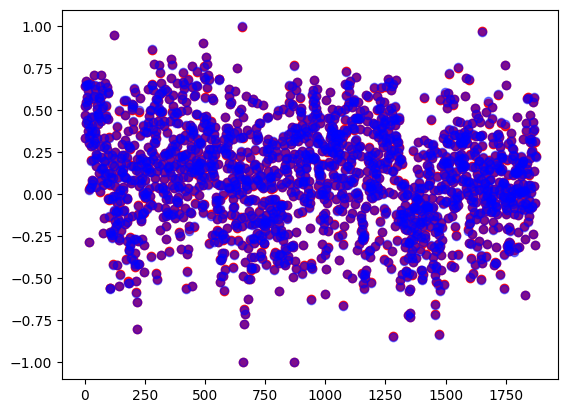

In [30]:
plt.scatter(range(len(X)), y_pred, color="red", alpha=0.9)
plt.scatter(range(len(X)), Y, color="blue", alpha=0.5)
plt.show()

In [31]:
print(X.shape)
print(Y.shape)
print(theta_star.shape)

torch.Size([1875, 2991])
torch.Size([1875, 1])
torch.Size([2991])


In [32]:
count = 0
for i in theta_star:
    if i != 0:
        count += 1

print(count)

2410


## Model fitting

In [33]:
data2 = utils.sample_dataset(1875, 9226, 0.05, 0, 1, data[0].numpy())

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 9226 is different from 2991)

In [12]:
data2[0].max()

tensor(27.5146143583267850, dtype=torch.float64)

In [ ]:
sorted(abs(data2[2]))

In [50]:
T = 10000
eta = 0.001
result = {}

for i in [0]:
    # SLR non-private
    k = 0 # use all features
    it_err, last_err = sparse_linreg_peeling.solve(data, k, T, eta, (0, 0, 0, False))
    result['a'] = it_err
    print(f'[no noise] k={k}, last_err={last_err}')

[no noise] k=0, last_err=0.7951654748462268


Text(0.5, 1.0, 'eta=0.01')

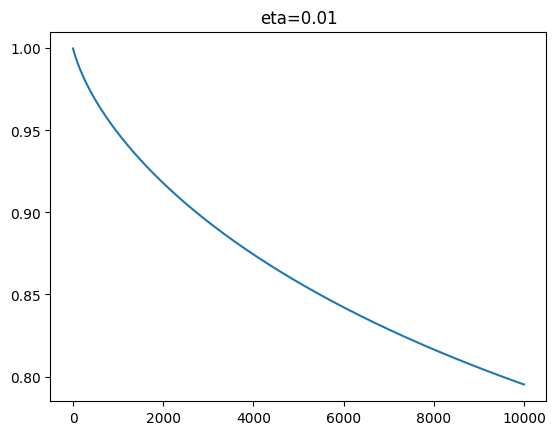

In [51]:
plt.plot(range(len(result['a'])), result['a'])
plt.title("eta=0.01")

In [47]:
T = 10000
eta = 0.01
result = {}

for i in [0]:
    # SLR non-private
    k = 0 # use all features
    it_err, last_err = sparse_linreg_peeling.solve(data, k, T, eta, (0, 0, 0, False))
    result['a'] = it_err
    print(f'[no noise] k={k}, last_err={last_err}')

[no noise] k=0, last_err=nan


Text(0.5, 1.0, 'eta=0.01')

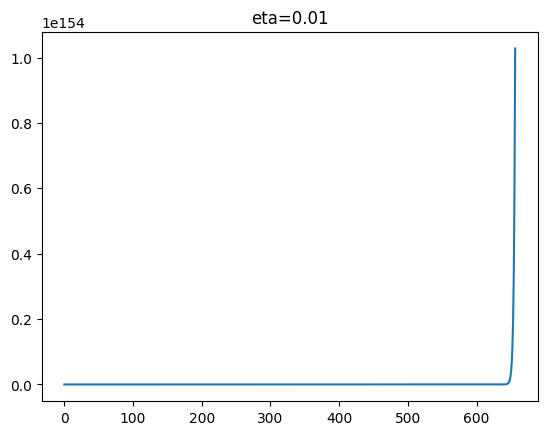

In [49]:
plt.plot(range(len(result['a'])), result['a'])
plt.title("eta=0.01")

In [138]:
utils.plot_error_by_iteration_and_dict_key(
    result,
    title=f'Iterations error, central',
    xlabel="iterations",
    ylabel='||theta_t - theta*||2',
    line_label="(d, dp)")

KeyError: 'non-private'

<Figure size 1000x1000 with 0 Axes>